# Homerork 5. Transformers

Practice (10-15 points):
First Option (Easier) - Apply [Sentence Classification/Sentence Regression](#Sentence_Classification) approach to [CommonLit - Evaluate Student Summaries](https://www.kaggle.com/competitions/commonlit-evaluate-student-summaries)

Max Base Points: 10
- [x] Tune `BERT` / `DEBERTA` or other bert-like models, maybe re-write it. Tune all other hyper-params.
- [x] Try different optimizers lr schedulers 
- [x] Implement Cross-Validation and add test houldout
- [ ] Make a submit to Kaggle

## Data

In [4]:
import os

import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import gensim
import nltk
import re
import spacy
import matplotlib.pyplot as plt

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, LeaveOneGroupOut, cross_val_score, GroupKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler, FunctionTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.linear_model import LinearRegression, Ridge

In [6]:
# set random seed
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    
seed_everything(seed=42)

In [7]:
# dir = "../data/"
dir = "/kaggle/input/"
prompts_train = pd.read_csv(os.path.join(dir, "commonlit-evaluate-student-summaries/prompts_train.csv"))
summaries_train = pd.read_csv(os.path.join(dir, "commonlit-evaluate-student-summaries/summaries_train.csv"))

prompts_test = pd.read_csv(os.path.join(dir, "commonlit-evaluate-student-summaries/prompts_test.csv"))
summaries_test = pd.read_csv(os.path.join(dir, "commonlit-evaluate-student-summaries/summaries_test.csv"))

sample_submission = pd.read_csv(os.path.join(dir, "commonlit-evaluate-student-summaries/sample_submission.csv"))

### Dataset structure

The task falls into the category of **supervised learning** since target scores are provided for the training dataset. 

The provided dataset consists of two parts: **prompts**, i.e. summarization tasks, given to students, and actual **students' summaries**. Train part of those summaries also contains the assigned score. 

**Summaries in the training set**
- `student_id` - The ID of the student writer.
- `prompt_id` - The ID of the prompt which links to the prompt file.
- `text` - The full text of the student's summary.
- `content` - The content score for the summary. The first target.
- `wording` - The wording score for the summary. The second target.

**The four training set prompts. Each prompt comprises the complete summarization assignment given to students.**
- `prompt_id` - The ID of the prompt which links to the summaries file.
- `prompt_question` - The specific question the students are asked to respond to.
- `prompt_title` - A short-hand title for the prompt.
- `prompt_text` - The full prompt text.

### Target values

The target, i.e. the score of the student's summary, consists of two parts: *wording score* and *content score*. Those scores are provided for the train part. Although there is no explicit description what criteries were used for those scores during the evaluation, it can be assumed that the *content score* should represent how well the summary summarizes the proposed text, while the *wording score* evaluates the summary from the writing perspective. An important consequence from this assumption is that the *wording score* doesn't depend on the prompt question content.  

### Evaluation Metric

The performance of the model will be estimated based on the mean columnwise RMSE:

$$MCRMSE = \frac{1}{N_t} \sum\limits_{j=1}^{N_t} \left(\frac1n \sum\limits_{i=1}^n (y_{ij} - \hat{y}_{ij})^2\right)^\frac12$$

In our case there are two target values, i.e. $N_t = 2$. Since the number of independent RMSEs is fixed, minimization of the MCRMSE is equivalent to the separate minimization of RMSE for each target value. This means that the models for *writing* and *content* score can be trained and optimized separately based on the RMSE.

## Data Preparation and EDA

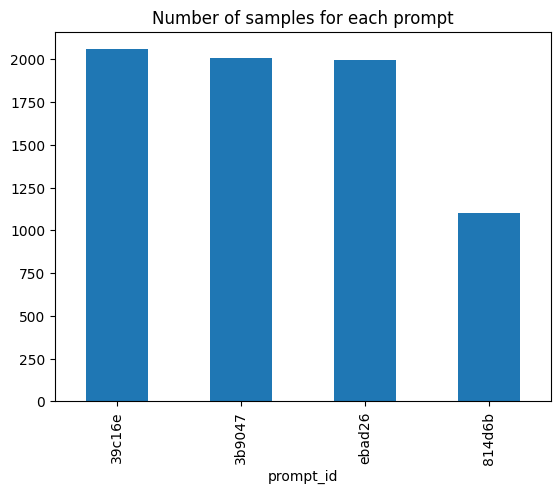

In [8]:
summaries_train['prompt_id'].value_counts().plot(kind='bar')
plt.title("Number of samples for each prompt")
plt.show()

### Target distribution

Let's take a look at the distributions of the target scores

From the plots we can assume that possible range for both scores is (-3, 5). The *content* is distributed more smoothly.

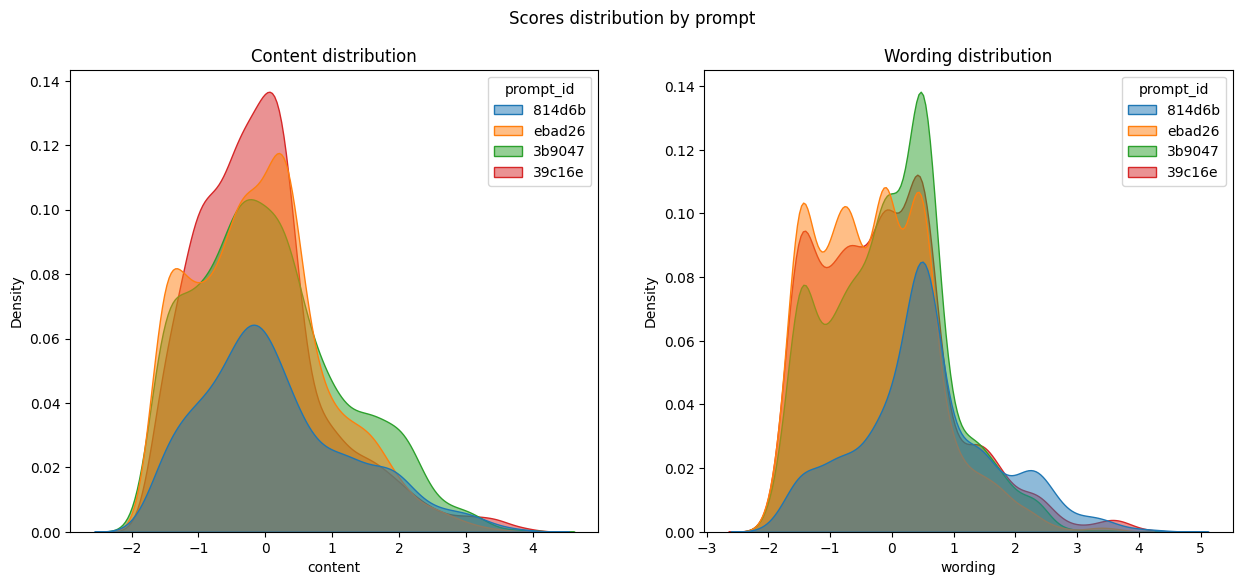

In [9]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axs[0].set_title("Content distribution")
axs[1].set_title("Wording distribution")
sns.kdeplot(data=summaries_train, x="content",color="b", alpha=.5, fill=True, ax=axs[0], hue='prompt_id')
sns.kdeplot(data=summaries_train, x="wording",color="r", alpha=.5, fill=True, ax=axs[1], hue='prompt_id')

plt.suptitle("Scores distribution by prompt")
plt.show()

Prompt `814d6b` has less samples than 3 others, yet distributions of target scores for each prompt more or less similiar.

### Combining prompt and summaries

In [10]:
train = summaries_train.merge(prompts_train, how="left", on="prompt_id")
test = summaries_test.merge(prompts_test, how="left", on="prompt_id")

In [11]:
train['prompt_and_summary'] = train['prompt_question'].str.cat(train[['prompt_title', 'prompt_text', 'text']], sep="\n")

In [12]:
print(train.loc[0, 'prompt_and_summary'])

Summarize how the Third Wave developed over such a short period of time and why the experiment was ended.
The Third Wave
Background 
The Third Wave experiment took place at Cubberley High School in Palo Alto, California during the first week of April 1967. History teacher Ron Jones, finding himself unable to explain to his students how people throughout history followed the crowd even when terrible things were happening, decided to demonstrate it to his students through an experiment. Jones announced that he was starting a movement aimed to eliminate democracy. Jones named the movement “The Third Wave” as a symbol of strength, referring to the mythical belief that the third in a series of waves is the strongest. One of the central points of this movement was that democracy’s main weakness is that it favors the individual over the whole community. Jones emphasized this main point of the movement when he created this catchy motto: “Strength through discipline, strength through community,

In [13]:
gkf = GroupKFold(n_splits=4)

for i, (_, val_index) in enumerate(gkf.split(train, groups=train["prompt_id"])):
    train.loc[val_index, "fold"] = i

train.head()

,student_id,prompt_id,text,content,wording,prompt_question,prompt_title,prompt_text,prompt_and_summary,fold
0,000e8c3c7ddb,814d6b,The third wave was an experimentto see how peo...,0.205683,0.380538,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,Summarize how the Third Wave developed over su...,3.0
1,0020ae56ffbf,ebad26,They would rub it up with soda to make the sme...,-0.548304,0.506755,Summarize the various ways the factory would u...,Excerpt from The Jungle,"With one member trimming beef in a cannery, an...",Summarize the various ways the factory would u...,2.0
2,004e978e639e,3b9047,"In Egypt, there were many occupations and soci...",3.128928,4.231226,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,"In complete sentences, summarize the structure...",1.0
3,005ab0199905,3b9047,The highest class was Pharaohs these people we...,-0.210614,-0.471415,"In complete sentences, summarize the structure...",Egyptian Social Structure,Egyptian society was structured like a pyramid...,"In complete sentences, summarize the structure...",1.0
4,0070c9e7af47,814d6b,The Third Wave developed rapidly because the ...,3.272894,3.219757,Summarize how the Third Wave developed over su...,The Third Wave,Background \r\nThe Third Wave experiment took ...,Summarize how the Third Wave developed over su...,3.0


## Modeling

We will try three different schemes for learning rate scheduler: 
- cosine with warmup, small lr for body, large for head
- cosine with warmup and hard resets, small lr for body, large for head
- cosine with warmup, large lr for both head and body


There will be two separated models for wording and content scores. Wording model will take as input only summary text, whereis content model will take as input concatenated prompt and summary. 

Due to the time constraints we will perform validation for mentioned approaches on single holdout set (corresponding to one prompt). For both wording and content models snapshot with greatest validation score among all approaches will be chosen, and their combination will be submitted to the kaggle.

In [14]:
train_df = train[train['fold'] != 0]
val_df = train[train['fold'] == 0]

In [15]:
import transformers
from transformers import AutoModel, AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from transformers import DataCollatorWithPadding
from datasets import Dataset,load_dataset, load_from_disk
from transformers import TrainingArguments, Trainer
from datasets import load_metric, disable_progress_bar
from transformers import get_cosine_schedule_with_warmup, get_cosine_with_hard_restarts_schedule_with_warmup 
from torch.optim import AdamW

In [16]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
    
seed_everything(seed=42)

In [17]:
class CFG:
    model_name="debertav3base"
    num_train_epochs=3
    n_splits=4
    batch_size=4
    random_seed=42
    save_steps=300

In [18]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    rmse = mean_squared_error(labels, predictions, squared=False)
    return {"rmse": rmse}

def compt_score(content_true, content_pred, wording_true, wording_pred):
    content_score = mean_squared_error(content_true, content_pred)**(1/2)
    wording_score = mean_squared_error(wording_true, wording_pred)**(1/2)
    
    return (content_score + wording_score)/2

In [19]:
class ScoreRegressor:
    def __init__(self, 
                model_name: str,
                model_dir: str,
                text_col: str,
                target: str,
                max_length: int,
            ):
        self.text_col = text_col 
        self.target = target

        self.model_name = model_name
        self.model_dir = model_dir
        self.max_length = max_length
        
        self.tokenizer = AutoTokenizer.from_pretrained(f"/kaggle/input/{model_name}")
        self.model_config = AutoConfig.from_pretrained(f"/kaggle/input/{model_name}")
        
        self.model_config.update({
            "num_labels": 1,
            "problem_type": "regression",
        })
        
        seed_everything(seed=42)

        self.data_collator = DataCollatorWithPadding(
            tokenizer=self.tokenizer
        )

    def tokenize_function(self, examples: pd.DataFrame):
        labels = [examples[self.target]]
        tokenized = self.tokenizer(examples[self.text_col],
                        padding=False,
                        truncation=True,
                        max_length=self.max_length)
        return {
            **tokenized,
            "labels": labels,
        }
    
    def train(self, 
            model_variant: str,
            train_df: pd.DataFrame,
            valid_df: pd.DataFrame,
            batch_size: int,
            num_train_epochs: float,
            save_steps: int,
            scheduler_func,
            scheduler_args: dict,
            lr_body=float,
            lr_head=1e-3,
        ) -> None:
        
        train_df = train_df[[self.text_col, self.target]]
        valid_df = valid_df[[self.text_col, self.target]]
        
        model = AutoModelForSequenceClassification.from_pretrained(
            f"/kaggle/input/{self.model_name}", 
            config=self.model_config
        )
        
        optimizer = AdamW([
            {'params': list(model.deberta.parameters()), 'lr': lr_body},
            {'params': list(model.classifier.parameters()), 'lr': lr_head}
        ])
        
        scheduler = scheduler_func(
            optimizer,
            **scheduler_args
        )

        train_dataset = Dataset.from_pandas(train_df, preserve_index=False) 
        val_dataset = Dataset.from_pandas(valid_df, preserve_index=False) 
    
        train_tokenized_datasets = train_dataset.map(self.tokenize_function, batched=False)
        val_tokenized_datasets = val_dataset.map(self.tokenize_function, batched=False)

        model_var_dir = os.path.join(self.model_dir, str(model_variant)) 
        
        training_args = TrainingArguments(
            output_dir=model_var_dir,
            load_best_model_at_end=True, # select best model
            per_device_train_batch_size=batch_size,
            per_device_eval_batch_size=8,
            num_train_epochs=num_train_epochs,
            report_to='none',
            greater_is_better=False,
            save_strategy="steps",
            evaluation_strategy="steps",
            eval_steps=save_steps,
            save_steps=save_steps,
            metric_for_best_model="rmse",
            save_total_limit=1
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=train_tokenized_datasets,
            eval_dataset=val_tokenized_datasets,
            tokenizer=self.tokenizer,
            compute_metrics=compute_metrics,
            data_collator=self.data_collator,
            optimizers=(optimizer, scheduler)
        )

        trainer.train()
        
        model.save_pretrained(self.model_var_dir)
        self.tokenizer.save_pretrained(self.model_var_dir)

        
    def predict(self, test_df: pd.DataFrame, model_variant: str):
        test_ = test_df[self.text_cols]
    
        test_dataset = Dataset.from_pandas(test_, preserve_index=False) 
        test_tokenized_dataset = test_dataset.map(self.tokenize_function_test, batched=False)

        model = AutoModelForSequenceClassification.from_pretrained(f"{self.model_dir}")
        model.eval()

        model_var_dir = os.path.join(self.model_dir, str(model_variant)) 
        
        test_args = TrainingArguments(
            output_dir=model_var_dir,
            do_train = False,
            do_predict = True,
            per_device_eval_batch_size = 4,   
            dataloader_drop_last = False,
        )

        infer = Trainer(
                    model = model, 
                    tokenizer=self.tokenizer,
                    data_collator=self.data_collator,
                    args = test_args)

        preds = infer.predict(test_tokenized_dataset)[0]

        return preds

### Wording model

In [20]:
wording_max_len = int(train['text'].str.split().apply(len).max() * 1.5)

In [21]:
wording_model = ScoreRegressor(
    model_name=CFG.model_name,
    model_dir=f"/kaggle/working/wording_{CFG.model_name}/",
    text_col="text",
    target="wording",
    max_length=wording_max_len
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### Approach 1

In [22]:
scheduler_func = get_cosine_schedule_with_warmup
scheduler_args = dict(
    num_warmup_steps=0.1*CFG.num_train_epochs*(train_df.shape[0]/CFG.batch_size),
    num_training_steps=CFG.num_train_epochs*(train_df.shape[0]/CFG.batch_size),
)

In [27]:
wording_model.train(
    model_variant="cosine_lr",
    train_df=train_df,
    valid_df=val_df,
    batch_size=CFG.batch_size,
    num_train_epochs=CFG.num_train_epochs,
    save_steps=CFG.save_steps,
    lr_body=1e-5,
    scheduler_args=scheduler_args,
    scheduler_func=scheduler_func
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/debertav3base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/5108 [00:00<?, ?ex/s]

  0%|          | 0/2057 [00:00<?, ?ex/s]

Step,Training Loss,Validation Loss,Rmse
300,No log,0.526422,0.725549
600,0.709400,0.342380,0.585133
900,0.709400,0.394048,0.627732
1200,0.409300,0.296934,0.544916
1500,0.368500,0.304756,0.552047
1800,0.368500,0.418272,0.646740
2100,0.304600,0.288049,0.536702
2400,0.304600,0.302212,0.549738
2700,0.298900,0.319238,0.565012
3000,0.210500,0.293256,0.541531


#### Approach 2

In [22]:
scheduler_func = get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_args = dict(
    num_warmup_steps=0.1*CFG.num_train_epochs*(train_df.shape[0]/CFG.batch_size),
    num_training_steps=CFG.num_train_epochs*(train_df.shape[0]/CFG.batch_size),
    num_cycles=3
)

In [27]:
wording_model.train(
    model_variant="cosine_lr_hard_reset",
    train_df=train_df,
    valid_df=val_df,
    batch_size=CFG.batch_size,
    num_train_epochs=CFG.num_train_epochs,
    save_steps=CFG.save_steps,
    lr_body=1e-5,
    scheduler_args=scheduler_args,
    scheduler_func=scheduler_func
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/debertav3base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/5108 [00:00<?, ?ex/s]

  0%|          | 0/2057 [00:00<?, ?ex/s]

Step,Training Loss,Validation Loss,Rmse
300,No log,0.526422,0.725549
600,0.709400,0.342380,0.585133
900,0.709400,0.394048,0.627732
1200,0.409300,0.296934,0.544916
1500,0.368500,0.304756,0.552047
1800,0.368500,0.418272,0.646740
2100,0.304600,0.288049,0.536702
2400,0.304600,0.302212,0.549738
2700,0.298900,0.319238,0.565012
3000,0.210500,0.293256,0.541531


#### Approach 3

In [22]:
scheduler_func = get_cosine_schedule_with_warmup
scheduler_args = dict(
    num_warmup_steps=0.1*CFG.num_train_epochs*(train_df.shape[0]/CFG.batch_size),
    num_training_steps=CFG.num_train_epochs*(train_df.shape[0]/CFG.batch_size),
)

In [27]:
wording_model.train(
    model_variant="cosine_lr_large_lr_body",
    train_df=train_df,
    valid_df=val_df,
    batch_size=CFG.batch_size,
    num_train_epochs=CFG.num_train_epochs,
    save_steps=CFG.save_steps,
    lr_body=1e-3,
    scheduler_args=scheduler_args,
    scheduler_func=scheduler_func
)

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at /kaggle/input/debertav3base and are newly initialized: ['classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  0%|          | 0/5108 [00:00<?, ?ex/s]

  0%|          | 0/2057 [00:00<?, ?ex/s]

Step,Training Loss,Validation Loss,Rmse
300,No log,0.526422,0.725549
600,0.709400,0.342380,0.585133
900,0.709400,0.394048,0.627732
1200,0.409300,0.296934,0.544916
1500,0.368500,0.304756,0.552047
1800,0.368500,0.418272,0.646740
2100,0.304600,0.288049,0.536702
2400,0.304600,0.302212,0.549738
2700,0.298900,0.319238,0.565012
3000,0.210500,0.293256,0.541531


### Content model

In [28]:
content_max_len = int(train['prompt_and_summary'].str.split().apply(len).max() * 1.5)

In [30]:
content_model = ScoreRegressor(
    model_name=CFG.model_name,
    model_dir=f"/kaggle/working/content_{CFG.model_name}/",
    text_col="prompt_and_summary",
    target="content",
    max_length=content_max_len
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/opt/conda/lib/python3.10/site-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


#### Approach 1

In [31]:
scheduler_func = get_cosine_schedule_with_warmup
scheduler_args = dict(
    num_warmup_steps=0.1*CFG.num_train_epochs*(train_df.shape[0]/CFG.batch_size),
    num_training_steps=CFG.num_train_epochs*(train_df.shape[0]/CFG.batch_size),
)

In [32]:
wording_model.train(
    model_variant="cosine_lr",
    train_df=train_df,
    valid_df=val_df,
    batch_size=CFG.batch_size // 2,
    num_train_epochs=CFG.num_train_epochs,
    save_steps=CFG.save_steps * 2,
    lr_body=1e-5,
    scheduler_args=scheduler_args,
    scheduler_func=scheduler_func
)

Some weights of the model checkpoint at /kaggle/input/debertav3base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from

  0%|          | 0/5108 [00:00<?, ?ex/s]

  0%|          | 0/2057 [00:00<?, ?ex/s]

Step,Training Loss,Validation Loss,Rmse
600,0.808000,0.412895,0.642569
1200,0.516700,0.570672,0.755429
1800,0.440900,0.396237,0.629473
2400,0.400700,0.321907,0.567368
3000,0.305700,0.309583,0.556402
3600,0.279800,0.305002,0.552270


KeyboardInterrupt: 

#### Approach 2

In [31]:
scheduler_func = get_cosine_with_hard_restarts_schedule_with_warmup
scheduler_args = dict(
    num_warmup_steps=0.1*CFG.num_train_epochs*(train_df.shape[0]/CFG.batch_size),
    num_training_steps=CFG.num_train_epochs*(train_df.shape[0]/CFG.batch_size),
    num_cycles=3
)

In [32]:
wording_model.train(
    model_variant="cosine_lr_hard_resetb",
    train_df=train_df,
    valid_df=val_df,
    batch_size=CFG.batch_size // 2,
    num_train_epochs=CFG.num_train_epochs,
    save_steps=CFG.save_steps * 2,
    lr_body=1e-5,
    scheduler_args=scheduler_args,
    scheduler_func=scheduler_func
)

Some weights of the model checkpoint at /kaggle/input/debertav3base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from

  0%|          | 0/5108 [00:00<?, ?ex/s]

  0%|          | 0/2057 [00:00<?, ?ex/s]

Step,Training Loss,Validation Loss,Rmse
600,0.808000,0.412895,0.642569
1200,0.516700,0.570672,0.755429
1800,0.440900,0.396237,0.629473
2400,0.400700,0.321907,0.567368
3000,0.305700,0.309583,0.556402
3600,0.279800,0.305002,0.552270


KeyboardInterrupt: 

#### Approach 3

In [31]:
scheduler_func = get_cosine_schedule_with_warmup
scheduler_args = dict(
    num_warmup_steps=0.1*CFG.num_train_epochs*(train_df.shape[0]/CFG.batch_size),
    num_training_steps=CFG.num_train_epochs*(train_df.shape[0]/CFG.batch_size),
)

In [32]:
wording_model.train(
    model_variant="cosine_lr_large_lr_body",
    train_df=train_df,
    valid_df=val_df,
    batch_size=CFG.batch_size // 2,
    num_train_epochs=CFG.num_train_epochs,
    save_steps=CFG.save_steps * 2,
    lr_body=1e-3,
    scheduler_args=scheduler_args,
    scheduler_func=scheduler_func
)

Some weights of the model checkpoint at /kaggle/input/debertav3base were not used when initializing DebertaV2ForSequenceClassification: ['mask_predictions.dense.bias', 'mask_predictions.dense.weight', 'mask_predictions.classifier.bias', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.LayerNorm.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DebertaV2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from

  0%|          | 0/5108 [00:00<?, ?ex/s]

  0%|          | 0/2057 [00:00<?, ?ex/s]

Step,Training Loss,Validation Loss,Rmse
600,0.808000,0.412895,0.642569
1200,0.516700,0.570672,0.755429
1800,0.440900,0.396237,0.629473
2400,0.400700,0.321907,0.567368
3000,0.305700,0.309583,0.556402
3600,0.279800,0.305002,0.552270


KeyboardInterrupt: 